# Code to reproduce Tables 4-8, and Figure 5, from the paper 'Improving cognitive-state analysis from eye gaze with synthetic eye-movement data'
* see: https://www.sciencedirect.com/science/article/pii/S0097849324000281

In [ ]:
from __future__ import annotations
import argparse
import os
import random
from tqdm.notebook import tqdm
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.stats import ttest_ind, ttest_1samp
from scipy import interpolate
from sklearn import metrics
import joblib

from sp_eyegan.gpu_selection import select_gpu
from sp_eyegan.load_sb_sat_data import get_sb_sat_data
from sp_eyegan.model import contrastive_learner
import config as config

## Helper Functions

In [2]:
def get_metric_dict_for_setting(inspect_key = 'normalized Ethnicity',
                        inspect_list = ['Caucasian','Black','Asian','Hispanic'],                        
                        demo_dict = dict(),
                        result_list = [],
                        only_equal = False,
                        verbose = 1,
                        ):
    if verbose == 1:
        disable = False
    else:
        disable = True
    metric_dict = dict()
    for fold_nr in tqdm(np.arange(len(result_list)), disable = disable):
        cur_data = result_list[fold_nr]
        scores = cur_data['scores']
        labels = cur_data['labels']
        person_one = cur_data['person_one']
        person_two = cur_data['person_two']        
        
        person_one_list = person_one
        person_two_list = person_two
        
        if demo_dict is not None:
            person_one_label = []
            for i in range(len(person_one_list)):
                if inspect_key is not None:
                    person_one_label.append(demo_dict[inspect_key][person_one_list[i]])
                else:
                    person_one_label.append(demo_dict[person_one_list[i]])

            person_two_label = []
            for i in range(len(person_two_list)):
                if inspect_key is not None:            
                    person_two_label.append(demo_dict[inspect_key][person_two_list[i]])
                else:
                    person_two_label.append(demo_dict[person_two_list[i]])
        
        # all persons
        fpr, tpr, thresholds = metrics.roc_curve(labels, scores, pos_label=1)
        if 'all' not in metric_dict:
            metric_dict['all'] = {'fprs':[],
                                  'tprs':[],
                                  'thresholds':[]}
        metric_dict['all']['fprs'].append(fpr)
        metric_dict['all']['tprs'].append(tpr)
        metric_dict['all']['thresholds'].append(thresholds)
        
        if demo_dict is not None:
            # all combinations
            for key_1 in inspect_list:
                for key_2 in inspect_list:
                    if only_equal:
                        if key_1 != key_2:
                            continue
                    use_ids = []
                    for i in range(len(person_one_label)):
                        # all instances matching the criterion
                        if person_one_label[i] == key_1 and person_two_label[i] == key_2:
                            use_ids.append(i)
                        # all matches; matching the criterion
                        if person_one_label[i] == key_1 and labels[i] == 1:
                            use_ids.append(i)
                    use_ids = list(set(use_ids))
                    fpr, tpr, thresholds = metrics.roc_curve(np.array(labels)[use_ids],
                                                             np.array(scores)[use_ids],
                                                             pos_label=1)
                    cur_key = key_1 + ' - ' + str(key_2)
                    if cur_key not in metric_dict:
                        metric_dict[cur_key] = {'fprs':[],
                                              'tprs':[],
                                              'thresholds':[]}
                    metric_dict[cur_key]['fprs'].append(fpr)
                    metric_dict[cur_key]['tprs'].append(tpr)
                    metric_dict[cur_key]['thresholds'].append(thresholds)
    return metric_dict

## Table 4 (SB-SAT dataset)

In [3]:
# params
result_path = config.CSV_RESULTS_FILE.replace('../','')
result_pd = pd.read_csv(result_path)
dst_dir = 'results/'

In [4]:
problems = ['subj_acc','acc','difficulty','native',]
names    = ['General Reading Comprehension',
            'Text Comprehension',
            'Text Difficulty',
            'Native Reader',
            ]

name_mapping = {'ekyt':'EKYT',
                'clrgaze':'CLRGaze',
                }

table_name_mapping = {'CLRGaze (CP) fine-tuning':'Pre-training & fine-tuning (CLRGaze)',
    'CLRGaze (CP) random forest':'Random forest on feature embeddings (CLRGaze)',
    'EKYT (CP) fine-tuning':'Pre-training & fine-tuning (EKYT)',
    'EKYT (CP) random forest':'Random forest on feature embeddings (EKYT)',
    'EKYT':'Without pretraining (EKYT)',
    'CLRGaze':'Without pre-training (CLRGaze)',
    'RF_rf':'Random forest on engineered features'}
g_r_c_results = {'BEyeLSTM':'0.608 $\pm$ 0.037'}
t_c_results ={'BEyeLSTM':'0.542 $\pm$ 0.015'}
t_d_results = {'BEyeLSTM':'0.710 $\pm$ 0.017'}
n_r_results = {'BEyeLSTM':'0.670 $\pm$ 0.025'}

In [5]:
folds = 5
flag_skip_scratch = True
popmean = 0.5

# collect neural network results
for i in range(len(problems)):
    cur_prob = problems[i]
    cur_name = names[i]
    #cur_col = cur_prob + '_five_sec_eval_mean_auc'
    cur_col = cur_prob + '_mean_auc'
    model_names = list(result_pd['model_name'])
    values = list(result_pd[cur_col])
    fold_values = []
    for fold_i in range(folds):
        cur_col = cur_prob + '_auc_fold_' + str(fold_i)
        fold_values.append(list(result_pd[cur_col]))
    fold_values = np.array(fold_values).T
    #print('problem: ' + str(cur_name))
    name_values_dict = dict()
    for j in range(len(values)):
        cur_model_name = model_names[j]
        cur_mean = np.round(np.mean(fold_values[j,:]),decimals=3)
        cur_stderr = np.round(np.std(fold_values[j,:])/np.sqrt(folds),decimals=3)
        if cur_model_name[0].isupper():
            cur_model_name = cur_model_name
        elif '_scratch' in cur_model_name:
            if flag_skip_scratch:
                continue
            cur_model_name = cur_model_name.split('_scratch')[0]
        else:
            if 'rf' in cur_model_name:
                cur_model_name = name_mapping[cur_model_name.split('_')[0]] + ' (CP) random forest'
            else:
                cur_model_name = name_mapping[cur_model_name.split('_')[0]] + ' (CP) fine-tuning'
        flag_add = True
        if cur_model_name in name_values_dict:
            flag_add = False
            mean, values, name = name_values_dict[cur_model_name]
            if cur_mean > mean:
                flag_add = True
        if flag_add:
            name_values_dict[cur_model_name] = (cur_mean, fold_values[j,:], model_names[j])
        #print('    ' + cur_model_name + ': ' + str(cur_mean) +\
        #     ' $\pm$ ' + str(cur_stderr))
    for model_name in name_values_dict:
        mean, values, name = name_values_dict[model_name]
        cur_mean = np.round(np.mean(values),decimals=3)
        cur_stderr = np.round(np.std(values)/np.sqrt(len(values)),decimals=3)
        # tests if better than random guessing
        better_random_pvalue = ttest_1samp(a=values,popmean=popmean,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        
        # test if better than w/o pre-training
        if model_name != 'EKYT' and model_name != 'CLRGaze':
            if model_name.lower().startswith('ekyt'):
                base_values = name_values_dict['EKYT'][1]
            elif model_name.lower().startswith('clrgaze'):
                base_values = name_values_dict['CLRGaze'][1]
        tt_test_pvalue = ttest_ind(base_values,values,alternative='two-sided').pvalue
        if tt_test_pvalue < 0.05:
            cur_p_value_add_str += '$\dagger$'
        else:
            cur_p_value_add_str += ''
        
        #print('    ' + model_name + ' & ' + str(cur_mean) +\
        #     ' $\pm$ ' + str(cur_stderr) + cur_p_value_add_str)
        
        cur_string = str(cur_mean) +' $\pm$ ' + str(cur_stderr)
        if cur_prob == 'subj_acc':
            g_r_c_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'acc':
            t_c_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'native':
            n_r_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'difficulty':
            t_d_results[table_name_mapping[model_name]] = cur_string
                
# collect rf results
result_path = config.CSV_RESULTS_FILE.replace('.csv','_rf.csv').replace('../','')
result_pd = pd.read_csv(result_path)
folds = 5
flag_skip_scratch = True
popmean = 0.5

model_names = ['RF_rf']

for i in range(len(problems)):
    cur_prob = problems[i]
    cur_name = names[i]
    #cur_col = cur_prob + '_five_sec_eval_mean_auc'
    cur_col = cur_prob + '_mean_auc'
    #model_names = list(result_pd['model_name'])
    values = list(result_pd[cur_col])
    fold_values = []
    for fold_i in range(folds):
        cur_col = cur_prob + '_auc_fold_' + str(fold_i)
        fold_values.append(list(result_pd[cur_col]))
    fold_values = np.array(fold_values).T
    #print('problem: ' + str(cur_name))
    name_values_dict = dict()
    for j in range(len(values)):
        cur_model_name = model_names[j]
        cur_mean = np.round(np.mean(fold_values[j,:]),decimals=3)
        cur_stderr = np.round(np.std(fold_values[j,:])/np.sqrt(folds),decimals=3)
        if cur_model_name[0].isupper():
            cur_model_name = cur_model_name
        elif '_scratch' in cur_model_name:
            if flag_skip_scratch:
                continue
            cur_model_name = cur_model_name.split('_scratch')[0]
        else:
            if 'rf' in cur_model_name:
                cur_model_name = name_mapping[cur_model_name.split('_')[0]] + ' (CP) random forest'
            else:
                cur_model_name = name_mapping[cur_model_name.split('_')[0]] + ' (CP) fine-tuning'
        flag_add = True
        if cur_model_name in name_values_dict:
            flag_add = False
            mean, values, name = name_values_dict[cur_model_name]
            if cur_mean > mean:
                flag_add = True
        if flag_add:
            name_values_dict[cur_model_name] = (cur_mean, fold_values[j,:], model_names[j])
        #print('    ' + cur_model_name + ': ' + str(cur_mean) +\
        #     ' $\pm$ ' + str(cur_stderr))
    for model_name in name_values_dict:
        mean, values, name = name_values_dict[model_name]
        cur_mean = np.round(np.mean(values),decimals=3)
        cur_stderr = np.round(np.std(values)/np.sqrt(len(values)),decimals=3)
        # tests if better than random guessing
        better_random_pvalue = ttest_1samp(a=values,popmean=popmean,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        
        # test if better than w/o pre-training
        if model_name != 'EKYT' and model_name != 'CLRGaze':
            if model_name.lower().startswith('ekyt'):
                base_values = name_values_dict['EKYT'][1]
            elif model_name.lower().startswith('clrgaze'):
                base_values = name_values_dict['CLRGaze'][1]
        tt_test_pvalue = ttest_ind(base_values,values,alternative='two-sided').pvalue
        if tt_test_pvalue < 0.05:
            cur_p_value_add_str += '$\dagger$'
        else:
            cur_p_value_add_str += ''
        
        #print('    ' + model_name + ' & ' + str(cur_mean) +\
        #     ' $\pm$ ' + str(cur_stderr) + cur_p_value_add_str)# + ' ' + str(name))
        cur_string = str(cur_mean) +' $\pm$ ' + str(cur_stderr)
        if cur_prob == 'subj_acc':
            g_r_c_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'acc':
            t_c_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'native':
            n_r_results[table_name_mapping[model_name]] = cur_string
        elif cur_prob == 'difficulty':
            t_d_results[table_name_mapping[model_name]] = cur_string

In [6]:
sbsat_result_dict = dict()
modelnames = ['BEyeLSTM',
             'Random forest on engineered features',
             'Without pretraining (EKYT)',
             'Pre-training & fine-tuning (EKYT)',
             'Random forest on feature embeddings (EKYT)',
             'Without pre-training (CLRGaze)',
             'Pre-training & fine-tuning (CLRGaze)',
             'Random forest on feature embeddings (CLRGaze)',
             ] 
sbsat_result_dict['Method'] = modelnames
task_names = names
task_dicts = [g_r_c_results, t_c_results, t_d_results, n_r_results]
for task_id in range(len(task_names)):
    task = task_names[task_id]
    task_dict = task_dicts[task_id]
    result_list = []
    for name in modelnames:
        result_list.append(task_dict[name])
    sbsat_result_dict[task] = result_list
pd.DataFrame(sbsat_result_dict)

,Method,General Reading Comprehension,Text Comprehension,Text Difficulty,Native Reader
0,BEyeLSTM,0.608 $\pm$ 0.037,0.542 $\pm$ 0.015,0.710 $\pm$ 0.017,0.670 $\pm$ 0.025
1,Random forest on engineered features,0.619 $\pm$ 0.039,0.584 $\pm$ 0.039,0.544 $\pm$ 0.013,0.737 $\pm$ 0.057
2,Without pretraining (EKYT),0.585 $\pm$ 0.015,0.566 $\pm$ 0.02,0.494 $\pm$ 0.021,0.55 $\pm$ 0.014
3,Pre-training & fine-tuning (EKYT),0.622 $\pm$ 0.029,0.574 $\pm$ 0.024,0.545 $\pm$ 0.006,0.721 $\pm$ 0.061
4,Random forest on feature embeddings (EKYT),0.575 $\pm$ 0.074,0.597 $\pm$ 0.026,0.501 $\pm$ 0.012,0.556 $\pm$ 0.057
5,Without pre-training (CLRGaze),0.569 $\pm$ 0.065,0.56 $\pm$ 0.055,0.516 $\pm$ 0.034,0.528 $\pm$ 0.046
6,Pre-training & fine-tuning (CLRGaze),0.577 $\pm$ 0.033,0.592 $\pm$ 0.032,0.566 $\pm$ 0.018,0.704 $\pm$ 0.05
7,Random forest on feature embeddings (CLRGaze),0.507 $\pm$ 0.05,0.562 $\pm$ 0.026,0.488 $\pm$ 0.016,0.577 $\pm$ 0.042


## Table 5 (Biometric verification on GazeBase dataset)

In [7]:
### list of models
to_eval_files = [   dst_dir + '/EKYT_fold0_biometric__dataset_gazebase_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/ekyt_random_window_size_5000_sd_0.1_sd_factor_1.25_embedding_size_128_stimulus_video_model_random_-1baseline_1000_fold0_biometric__dataset_gazebase_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/CLRGAZE_fold0_biometric__dataset_gazebase_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/clrgaze_random_window_size_5000_sd_0.1_sd_factor_1.25_embedding_size_512_stimulus_video_model_random_-1baseline_1000_fold0_biometric__dataset_gazebase_max_rounds4_num_folds5_window_size1.npz',
                ]

to_eval_names = ['EKYT (w/o pre-training)',
                 'EKYT (CP SP-EyeGAN) fine-tuning',
                 'CLRGaze (w/o pre-training)',
                 'CLRGaze (CP SP-EyeGAN) fine-tuning',
                 ]

table_name_mapping = {'EKYT (w/o pre-training)':'Without pre-training (EKYT)',
                        'EKYT (CP SP-EyeGAN) fine-tuning':'Pre-training & fine-tuning (EKYT)',
                        'EKYT (CP SP-EyeGAN) zero-shot':'Zero-shot with pre-training (EKYT)',
                        'CLRGaze (w/o pre-training)':'Without pre-training (CLRGaze)',
                        'CLRGaze (CP SP-EyeGAN) fine-tuning':'Pre-training & fine-tuning (CLRGaze)',
                        'CLRGaze (CP SP-EyeGAN) zero-shot':'Zero-shot with pre-training (CLRGaze)',
                     }

# params
window_size = 1
plot_points = 1000
xscale = 'log'
plot_random = True
plot_statistics = True
fontsize=14
inspect_thresholds = [0.1,0.01,0.001]
folds = 5

In [8]:
flag_recompute = False
gazebase_table_dict = {'Method':[],
                       'EER':[],
                      }
decimals = 3
for m_i in tqdm(np.arange(len(to_eval_files)), disable = True):
    metric_dict_path = to_eval_files[m_i].replace('_fold0','').replace('.npz','.joblib')
    if flag_recompute:
        result_list = []
        start = time.time()
        for f_i in tqdm(np.arange(folds), disable = True):
            try:
                cur_result = np.load(to_eval_files[m_i].replace('fold0','fold' + str(f_i)))
                result_list.append({'scores':cur_result['scores'],
                                    'labels':cur_result['labels'],
                                    'person_one':cur_result['person_one'],
                                    'person_two':cur_result['person_two'],
                                    })
            except:
                print('not found:' + to_eval_files[m_i].replace('fold0','fold' + str(f_i)))
                filename = to_eval_files[m_i].replace('fold0','fold' + str(f_i))
                source_dir = '/home/prasse/work/Projekte/AEye/aeye_synthetic_data/github_code_sp-eyegan/sp-eyegan/'
                os.system('cp ' + source_dir + filename + ' ' + filename)
                continue
        end = time.time() - start    
        #print('time to load the data: ' + str(end) + ' size: ' + str(len(result_list)))


        start = time.time()
        metric_dict = get_metric_dict_for_setting(  inspect_key = None,
                                                    inspect_list = [],                        
                                                    demo_dict = None,
                                                    result_list = result_list,
                                                    verbose = 0,
                                                  )
        if not os.path.exists(metric_dict_path):
            joblib.dump(metric_dict,metric_dict_path,compress=3,protocol=2)
    else:
        metric_dict = joblib.load(metric_dict_path)

    fprs = metric_dict['all']['fprs']
    tprs = metric_dict['all']['tprs']
    eers = []
    for i in range(len(fprs)):
        key_fmr = fprs[i]
        key_fnmr = 1 - tprs[i]
        cur_inter = interpolate.interp1d(key_fmr,key_fnmr)
        fprs_inter = np.linspace(0, 1, plot_points)
        fnrs_inter = cur_inter(fprs_inter)
        cur_eer = fprs_inter[np.nanargmin(np.absolute((fnrs_inter - fprs_inter)))]
        eers.append(cur_eer)
    better_random_pvalue = ttest_1samp(a=1. - np.array(eers),popmean=0.5,alternative = 'greater').pvalue
    if better_random_pvalue < 0.05:
        cur_p_value_add_str = '*'
    else:
        cur_p_value_add_str = ''
    #print(to_eval_names[m_i] + ' & ' + str(np.round(np.mean(eers),decimals=decimals)) +\
    #                                ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)) +\
    #         cur_p_value_add_str + '\\\\')
    gazebase_table_dict['Method'].append(table_name_mapping[to_eval_names[m_i]])
    gazebase_table_dict['EER'].append(str(np.round(np.mean(eers),decimals=decimals)) +\
                                    ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)))
        
    if 'fine-tuning' in to_eval_names[m_i]:
        metric_dict_path = to_eval_files[m_i].replace('_fold0','').replace('.npz','_zeroshot.joblib')
        if flag_recompute:
            result_list = []
            start = time.time()
            for f_i in tqdm(np.arange(folds), disable = True):
                try:
                    cur_result = np.load(to_eval_files[m_i].replace('fold0','fold' + str(f_i)))
                    result_list.append({'scores':cur_result['scores_zero_shot'],
                                        'labels':cur_result['labels_zero_shot'],
                                        'person_one':cur_result['person_one_zero_shot'],
                                        'person_two':cur_result['person_two_zero_shot'],
                                        })
                except:
                    continue
            end = time.time() - start    
            #print('time to load the data: ' + str(end) + ' size: ' + str(len(result_list)))


            start = time.time()
            metric_dict = get_metric_dict_for_setting(  inspect_key = None,
                                                        inspect_list = [],                        
                                                        demo_dict = None,
                                                        result_list = result_list,
                                                        verbose = 0,
                                                      )
            if not os.path.exists(metric_dict_path):
                joblib.dump(metric_dict,metric_dict_path,compress=3,protocol=2)
        else:
            metric_dict = joblib.load(metric_dict_path)
            
        print_name = to_eval_names[m_i].replace('fine-tuning','zero-shot')
        fprs = metric_dict['all']['fprs']
        tprs = metric_dict['all']['tprs']
        eers = []
        for i in range(len(fprs)):
            key_fmr = fprs[i]
            key_fnmr = 1 - tprs[i]
            cur_inter = interpolate.interp1d(key_fmr,key_fnmr)
            fprs_inter = np.linspace(0, 1, plot_points)
            fnrs_inter = cur_inter(fprs_inter)
            cur_eer = fprs_inter[np.nanargmin(np.absolute((fnrs_inter - fprs_inter)))]
            eers.append(cur_eer)
        better_random_pvalue = ttest_1samp(a=1. - np.array(eers),popmean=0.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        #print(print_name + ' &  ' + str(np.round(np.mean(eers),decimals=decimals)) +\
        #                                ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)) +\
        #             cur_p_value_add_str+ '\\\\')
        gazebase_table_dict['Method'].append(table_name_mapping[print_name])
        gazebase_table_dict['EER'].append(str(np.round(np.mean(eers),decimals=decimals)) +\
                                        ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)))
pd.DataFrame(gazebase_table_dict)

,Method,EER
0,Without pre-training (EKYT),0.165 $ \pm$ 0.004
1,Pre-training & fine-tuning (EKYT),0.169 $ \pm$ 0.003
2,Zero-shot with pre-training (EKYT),0.495 $ \pm$ 0.004
3,Without pre-training (CLRGaze),0.181 $ \pm$ 0.003
4,Pre-training & fine-tuning (CLRGaze),0.188 $ \pm$ 0.003
5,Zero-shot with pre-training (CLRGaze),0.493 $ \pm$ 0.003


## Table 6 (Biometric verification on JuDo dataset)

In [9]:
### list of models
to_eval_files = [   dst_dir + '/EKYT_fold0_biometric__dataset_judo_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/ekyt_random_window_size_5000_sd_0.1_sd_factor_1.25_embedding_size_128_stimulus_video_model_random_-1baseline_1000_fold0_biometric__dataset_judo_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/CLRGAZE_fold0_biometric__dataset_judo_max_rounds4_num_folds5_window_size1.npz',
                    dst_dir + '/clrgaze_random_window_size_5000_sd_0.1_sd_factor_1.25_embedding_size_512_stimulus_video_model_random_-1baseline_1000_fold0_biometric__dataset_judo_max_rounds4_num_folds5_window_size1.npz',
                    ]

to_eval_names = ['EKYT (w/o pre-training)',
                 'EKYT (CP SP-EyeGAN) fine-tuning',
                 'CLRGaze (w/o pre-training)',
                 'CLRGaze (CP SP-EyeGAN) fine-tuning',                 
                 ]



# params
window_size = 1
plot_points = 1000
xscale = 'log'
plot_random = True
plot_statistics = True
fontsize=14
inspect_thresholds = [0.1,0.01,0.001]
folds = 5

In [10]:
judo_table_dict = {'Method':[],
                       'EER':[],
                      }
decimals = 3
for m_i in tqdm(np.arange(len(to_eval_files)), disable = True):
    metric_dict_path = to_eval_files[m_i].replace('_fold0','').replace('.npz','.joblib')
    if flag_recompute:
        result_list = []
        start = time.time()
        for f_i in tqdm(np.arange(folds), disable = True):
            try:
                cur_result = np.load(to_eval_files[m_i].replace('fold0','fold' + str(f_i)))
                result_list.append({'scores':cur_result['scores'],
                                    'labels':cur_result['labels'],
                                    'person_one':cur_result['person_one'],
                                    'person_two':cur_result['person_two'],
                                    })
            except:
                continue
        end = time.time() - start    
        #print('time to load the data: ' + str(end) + ' size: ' + str(len(result_list)))


        start = time.time()
        metric_dict = get_metric_dict_for_setting(  inspect_key = None,
                                                    inspect_list = [],                        
                                                    demo_dict = None,
                                                    result_list = result_list,
                                                    verbose = 0,
                                                  )
        if not os.path.exists(metric_dict_path):
            joblib.dump(metric_dict,metric_dict_path,compress=3,protocol=2)
    else:
        metric_dict = joblib.load(metric_dict_path)
    

    fprs = metric_dict['all']['fprs']
    tprs = metric_dict['all']['tprs']
    eers = []
    for i in range(len(fprs)):
        key_fmr = fprs[i]
        key_fnmr = 1 - tprs[i]
        cur_inter = interpolate.interp1d(key_fmr,key_fnmr)
        fprs_inter = np.linspace(0, 1, plot_points)
        fnrs_inter = cur_inter(fprs_inter)
        cur_eer = fprs_inter[np.nanargmin(np.absolute((fnrs_inter - fprs_inter)))]
        eers.append(cur_eer)
    better_random_pvalue = ttest_1samp(a=1. - np.array(eers),popmean=0.5,alternative = 'greater').pvalue
    if better_random_pvalue < 0.05:
        cur_p_value_add_str = '*'
    else:
        cur_p_value_add_str = ''
    #print(to_eval_names[m_i] + ' & ' + str(np.round(np.mean(eers),decimals=decimals)) +\
    #                                ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)) +\
    #         cur_p_value_add_str + '\\\\')
    judo_table_dict['Method'].append(table_name_mapping[to_eval_names[m_i]])
    judo_table_dict['EER'].append(str(np.round(np.mean(eers),decimals=decimals)) +\
                                    ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)))
    
    if 'fine-tuning' in to_eval_names[m_i]:
        metric_dict_path = to_eval_files[m_i].replace('_fold0','').replace('.npz','_zeroshot.joblib')
        if flag_recompute:
            result_list = []
            start = time.time()
            for f_i in tqdm(np.arange(folds), disable = True):
                try:
                    cur_result = np.load(to_eval_files[m_i].replace('fold0','fold' + str(f_i)))
                    result_list.append({'scores':cur_result['scores_zero_shot'],
                                        'labels':cur_result['labels_zero_shot'],
                                        'person_one':cur_result['person_one_zero_shot'],
                                        'person_two':cur_result['person_two_zero_shot'],
                                        })
                except:
                    continue
            end = time.time() - start    
            #print('time to load the data: ' + str(end) + ' size: ' + str(len(result_list)))


            start = time.time()
            metric_dict = get_metric_dict_for_setting(  inspect_key = None,
                                                        inspect_list = [],                        
                                                        demo_dict = None,
                                                        result_list = result_list,
                                                        verbose = 0,
                                                      )
            if not os.path.exists(metric_dict_path):
                joblib.dump(metric_dict,metric_dict_path,compress=3,protocol=2)
        else:
            metric_dict = joblib.load(metric_dict_path)

        print_name = to_eval_names[m_i].replace('fine-tuning','zero-shot')
        fprs = metric_dict['all']['fprs']
        tprs = metric_dict['all']['tprs']
        eers = []
        for i in range(len(fprs)):
            key_fmr = fprs[i]
            key_fnmr = 1 - tprs[i]
            cur_inter = interpolate.interp1d(key_fmr,key_fnmr)
            fprs_inter = np.linspace(0, 1, plot_points)
            fnrs_inter = cur_inter(fprs_inter)
            cur_eer = fprs_inter[np.nanargmin(np.absolute((fnrs_inter - fprs_inter)))]
            eers.append(cur_eer)
        better_random_pvalue = ttest_1samp(a=1. - np.array(eers),popmean=0.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        #print(print_name + ' &  ' + str(np.round(np.mean(eers),decimals=decimals)) +\
        #                                ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)) +\
        #             cur_p_value_add_str+ '\\\\')
        judo_table_dict['Method'].append(table_name_mapping[print_name])
        judo_table_dict['EER'].append(str(np.round(np.mean(eers),decimals=decimals)) +\
                                        ' $ \pm$ ' + str(np.round(np.std(eers) / np.sqrt(len(eers)),decimals=decimals)))
pd.DataFrame(judo_table_dict)

,Method,EER
0,Without pre-training (EKYT),0.112 $ \pm$ 0.003
1,Pre-training & fine-tuning (EKYT),0.114 $ \pm$ 0.003
2,Zero-shot with pre-training (EKYT),0.49 $ \pm$ 0.002
3,Without pre-training (CLRGaze),0.109 $ \pm$ 0.002
4,Pre-training & fine-tuning (CLRGaze),0.124 $ \pm$ 0.004
5,Zero-shot with pre-training (CLRGaze),0.462 $ \pm$ 0.002


## Figure 5 (Gender classification)

In [11]:
models = ['EKYT',
         'ekyt_random_window_size_300_sd_0.05_sd_factor_1.25_embedding_size_128_stimulus_video_model_random_-1baseline_60',
         'CLRGAZE',
         'clrgaze_random_window_size_300_sd_0.05_sd_factor_1.25_embedding_size_512_stimulus_video_model_random_-1baseline_60',
         ]

table_name_mapping = {  'EKYT (w/o pre-training)':'Without pre-training (EKYT)',
                        'EKYT (CP SPEyeGAN) fine-tuning':'Pre-training & fine-tuning (EKYT)',
                        'EKYT (CP SPEyeGAN) random forest':'Random forest on feature embeddings (EKYT)',
                        'CLRGaze (w/o pre-training)':'Without pre-training (CLRGaze)',
                        'CLRGaze (CP SPEyeGAN) fine-tuning':'Pre-training & fine-tuning (CLRGaze)',
                        'CLRGaze (CP SPEyeGAN) random forest':'Random forest on feature embeddings (CLRGaze)',
                        'Random forest on human features':'Random forest on engineered features',
                     }

In [12]:
table_result_dict = {'Method':[],
                     'AUC':[]}
folds = 5
popmean = 0.5
flag_trial_level_evaluation = True
five_sec_eval = False

cur_aucs = []
for fold in range(folds):
    try:
        cur_results = joblib.load('results/RF_fold' + str(fold) + '_gender.joblib')
    except:
        break
    test_subjects = np.array(cur_results['test_subjects'])
    test_label    = np.array(cur_results['test_label'])
    test_trials = np.array(cur_results['test_trials'])
    predictions_rf   = np.array(cur_results['predictions_rf'])[:,1]
    predictions = predictions_rf
    
    unique_subjects = list(np.unique(test_subjects))
    u_label = []
    u_preds = []
    for u_s in range(len(unique_subjects)):
        cur_subject = unique_subjects[u_s]
        cur_instances = np.where(test_subjects == cur_subject)[0]
        cur_scores = predictions[cur_instances]
        cur_label = test_label[cur_instances]
        cur_trials = test_trials[cur_instances]
        if flag_trial_level_evaluation:
            unique_trials = list(np.unique(cur_trials))
            for t_s in range(len(unique_trials)):
                cur_trial = unique_trials[t_s]
                cur_instances = np.where(cur_trials == cur_trial)[0]
                u_label.append(int(np.unique(cur_label[cur_instances])))
                u_preds.append(np.mean(cur_scores[cur_instances]))
        else:                
            u_label.append(int(np.unique(cur_label)))
            u_preds.append(np.mean(cur_scores))

    subj_auc = roc_auc_score(u_label, u_preds)
    cur_aucs.append(subj_auc)
#print('    Random forest on human features & ' +\
#      str(np.round(np.mean(cur_aucs), decimals = 2)) +\
#      ' $\pm$ ' + str(str(np.round(np.std(cur_aucs) / np.sqrt(folds), decimals = 2))))
table_result_dict['Method'].append(table_name_mapping['Random forest on human features'])
table_result_dict['AUC'].append(str(np.round(np.mean(cur_aucs), decimals = 2)) +\
      ' $\pm$ ' + str(str(np.round(np.std(cur_aucs) / np.sqrt(folds), decimals = 2))))

In [13]:
folds = 5
popmean = 0.5
flag_trial_level_evaluation = True
five_sec_eval = False
num_trains = [-1,
              100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

model_heads = ['nn',
               'rf',
              ]

name_mapping = {'clrgaze':'CLRGaze',
                'ekyt':'EKYT',
                'CLRGAZE':'CLRGaze',
                'EKYT':'EKYT',
                }


overall_result_dicts = dict()
for num_train in num_trains:
    model_results_dicts = dict()
    #print('num_train: ' + str(num_train))
    #print('------------------------------------')
    for i in range(len(models)):
        for m_h in range(len(model_heads)):
            model_head = model_heads[m_h]
            cur_aucs = []
            cur_model = models[i] + '_fold0_gender.joblib'
            if num_train != -1:
                cur_model = cur_model.replace('_gender','_gender_num_train_' + str(num_train))
            if 'embedding_size' not in cur_model:
                model_name = name_mapping[cur_model.split('/')[-1].split('_')[0]] + ' (w/o pre-training)'
            else:
                model_name = name_mapping[cur_model.split('/')[-1].split('_')[0]] + ' (CP SPEyeGAN)'
            model_name += ' ' + model_head
            if 'w/o pre-training' in model_name and model_head != 'nn':
                break

            for fold in range(folds):
                cur_path = cur_model.replace('fold0','fold' + str(fold))
                try:
                    cur_result = joblib.load(dst_dir + cur_path)
                except:
                    print('not found: ' + str(cur_path))
                    continue
                    #try:
                    #    cur_result = joblib.load(result_dir + '/to_delete/' + cur_path)
                    #except:
                    #    continue
                test_subjects = np.array(cur_result['test_subjects'])
                test_label    = np.array(cur_result['test_label'])
                test_trials = np.array(cur_result['test_trials'])
                predictions_nn   = np.array(cur_result['predictions_nn'])
                predictions_rf   = np.array(cur_result['predictions_rf'])[:,1]
                predictions_distances   = np.array(cur_result['predictions_distances'])

                if model_head ==  'nn':
                    predictions = predictions_nn
                elif model_head == 'rf':
                    predictions = predictions_rf
                elif model_head == 'distances':
                    predictions = predictions_distances


                predictions[np.isnan(predictions)] = 0.0
                overall_auc = roc_auc_score(test_label, predictions)
                if five_sec_eval:
                    cur_aucs.append(overall_auc)
                else:
                    #print('overall_score: ' + str(overall_auc))

                    unique_subjects = list(np.unique(test_subjects))
                    #print('number of test subjects: ' + str(len(unique_subjects)))
                    u_label = []
                    u_preds = []
                    for u_s in range(len(unique_subjects)):
                        cur_subject = unique_subjects[u_s]
                        cur_instances = np.where(test_subjects == cur_subject)[0]
                        cur_scores = predictions[cur_instances]
                        cur_label = test_label[cur_instances]
                        cur_trials = test_trials[cur_instances]
                        if flag_trial_level_evaluation:
                            unique_trials = list(np.unique(cur_trials))
                            for t_s in range(len(unique_trials)):
                                cur_trial = unique_trials[t_s]
                                cur_instances = np.where(cur_trials == cur_trial)[0]
                                u_label.append(int(np.unique(cur_label[cur_instances])))
                                u_preds.append(np.mean(cur_scores[cur_instances]))
                        else:                
                            u_label.append(int(np.unique(cur_label)))
                            u_preds.append(np.mean(cur_scores))

                    subj_auc = roc_auc_score(u_label, u_preds)
                    cur_aucs.append(subj_auc)
                    #print(cur_model)
                    #sns.histplot(u_preds)
                    #plt.show()
                    #print('subj_auc: ' + str(subj_auc))

            model_results_dicts[model_name] = (cur_aucs, cur_model)
            
            better_random_pvalue = ttest_1samp(a=cur_aucs,popmean=popmean,alternative = 'greater').pvalue
            if better_random_pvalue < 0.05:
                cur_p_value_add_str = '*'
            else:
                cur_p_value_add_str = ''
                
            cur_p_value_model_str = ''
            if 'w/o' not in model_name:
                if model_name.startswith('EKYT'):
                    base_values = model_results_dicts['EKYT (w/o pre-training) nn'][0]
                elif model_name.startswith('CLRGaze'):
                    base_values = model_results_dicts['CLRGaze (w/o pre-training) nn'][0]
                tt_test_pvalue = ttest_ind(base_values,cur_aucs,alternative='two-sided').pvalue
                if tt_test_pvalue < 0.05 and np.mean(base_values) < np.mean(cur_aucs):
                    cur_p_value_model_str += '$\dagger$'
                else:
                    cur_p_value_model_str += ''
                model_name = model_name.replace('nn','fine-tuning').replace('rf','random forest')
            else:
                model_name = model_name.replace('nn','').strip()
            #print('    ' + model_name + ' & ' +\
            #      str(np.round(np.mean(cur_aucs), decimals = 2)) +\
            #      ' $\pm$ ' + str(str(np.round(np.std(cur_aucs) / np.sqrt(folds), decimals = 2))) +\
            #      cur_p_value_add_str + cur_p_value_model_str)# + ' folds: ' + str(len(cur_aucs))) 
            
            if num_train == -1:
                table_result_dict['Method'].append(table_name_mapping[model_name])
                table_result_dict['AUC'].append(str(np.round(np.mean(cur_aucs), decimals = 2)) +\
                  ' $\pm$ ' + str(str(np.round(np.std(cur_aucs) / np.sqrt(folds), decimals = 2))))
            overall_result_dicts[model_name + '_num_train_' + str(num_train)] = cur_aucs

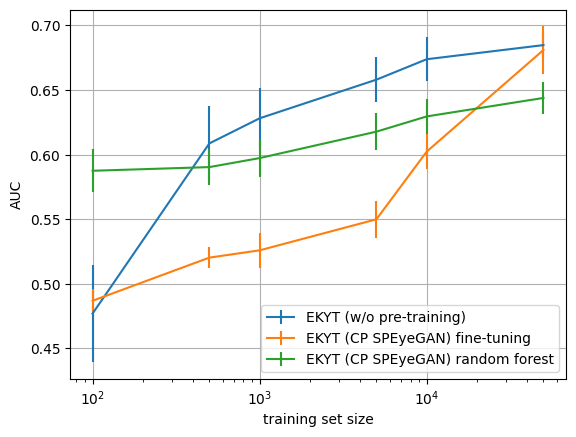

In [14]:
import matplotlib.pyplot as plt
model_names = ['EKYT (w/o pre-training)',
                'EKYT (CP SPEyeGAN) fine-tuning',
                'EKYT (CP SPEyeGAN) random forest',
              ]

use_num_trains = [100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

for model_name in model_names:
    mean_aucs = []
    std_aucs = []
    for num_train in use_num_trains:
        cur_aucs = overall_result_dicts[model_name + '_num_train_' + str(num_train)]
        mean_aucs.append(np.mean(cur_aucs))
        std_aucs.append(np.std(cur_aucs) / np.sqrt(len(cur_aucs)))
    plt.errorbar(use_num_trains,mean_aucs,std_aucs, label=model_name)
plt.legend()
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.xscale('log')
plt.grid()
plt.show()

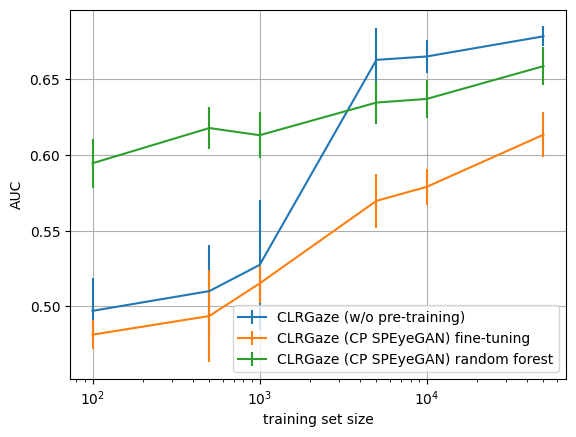

In [15]:
model_names = ['CLRGaze (w/o pre-training)',
                'CLRGaze (CP SPEyeGAN) fine-tuning',
                'CLRGaze (CP SPEyeGAN) random forest',
              ]

use_num_trains = [100,
              500,
              1000,
              5000,
              10000,
              50000,
             ]

for model_name in model_names:
    mean_aucs = []
    std_aucs = []
    for num_train in use_num_trains:
        cur_aucs = overall_result_dicts[model_name + '_num_train_' + str(num_train)]
        mean_aucs.append(np.mean(cur_aucs))
        std_aucs.append(np.std(cur_aucs) / np.sqrt(len(cur_aucs)))
    plt.errorbar(use_num_trains,mean_aucs,std_aucs, label=model_name)
plt.legend()
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.xscale('log')
plt.grid()
plt.show()

## Table 7 (Gender classification on Gaze on Faces dataset)

In [16]:
pd.DataFrame(table_result_dict)

,Method,AUC
0,Random forest on engineered features,0.68 $\pm$ 0.02
1,Without pre-training (EKYT),0.68 $\pm$ 0.01
2,Pre-training & fine-tuning (EKYT),0.68 $\pm$ 0.01
3,Random forest on feature embeddings (EKYT),0.65 $\pm$ 0.01
4,Without pre-training (CLRGaze),0.66 $\pm$ 0.01
5,Pre-training & fine-tuning (CLRGaze),0.6 $\pm$ 0.02
6,Random forest on feature embeddings (CLRGaze),0.66 $\pm$ 0.01


## Table 8 (ADHD detection)

In [17]:
adhd_files =  ['EKYT',
             'ekyt_random_window_size_600_sd_0.05_sd_factor_1.25_embedding_size_128_stimulus_video_model_random_-1baseline_120',
             'CLRGAZE',
             'clrgaze_random_window_size_600_sd_0.05_sd_factor_1.25_embedding_size_512_stimulus_video_model_random_-1baseline_120',
            ]

name_mapping = {'clrgaze':'CLRGaze',
                'ekyt':'EKYT',
                'CLRGAZE':'CLRGaze',
                'EKYT':'EKYT',
                }

decimals = 3

videos = ['Video_Fractals',
          'Video_The_Present',
          'Video_Despicable_Me',
          'Video_Diary_of_a_Wimpy_Kid_Trailer',
         ]

video_name_mapping = {'Video_Fractals':'Fun with Fractals',
                      'Video_The_Present':'The Present',
                      'Video_Despicable_Me':'Despicable Me',
                      'Video_Diary_of_a_Wimpy_Kid_Trailer':'Diary of a Wimpy Kid',
                     }

adhd_table_dict ={'Method':['SOTA CNN'],
                  'Fun with Fractals':['0.646 $\pm$ 0.025'],
                  'The Present':['0.554 $\pm$ 0.016'],
                  'Despicable Me':['0.544 $\pm$ 0.01'],
                  'Diary of a Wimpy Kid':['0.503 $\pm$ 0.01']}

table_name_mapping = {'RF with engineered features':'Random forest on engineered features',
                        'EKYT (w/o pre-training)':'Without pre-training (EKYT)',
                        'EKYT (CP SP-EyeGAN) fine-tuning':'Pre-training & fine-tuning (EKYT)',
                        'EKYT (CP SP-EyeGAN) random forest':'Random forest on feature embeddings (EKYT)',
                        'CLRGaze (w/o pre-training)':'Without pre-training (CLRGaze)',
                        'CLRGaze (CP SP-EyeGAN) fine-tuning':'Pre-training & fine-tuning (CLRGaze)',
                        'CLRGaze (CP SP-EyeGAN) random forest':'Random forest on feature embeddings (CLRGaze)',
                     }

In [18]:
for video in videos:
    #print('evaluate ' + video)
    model_result_dicts = dict()
    file = 'RF_adhd_video_' + video + '.joblib'
    cur_path = dst_dir + file
    cur_model = file.split('_')[0]
    try:
        cur_data = joblib.load(cur_path)
    except:
        continue
    auc_rounds_rf = cur_data['auc_rounds_rf']
    cur_model = cur_model + ' with engineered features'
    better_random_pvalue = ttest_1samp(a=np.array(auc_rounds_rf).ravel(),popmean=.5,alternative = 'greater').pvalue
    if better_random_pvalue < 0.05:
        cur_p_value_add_str = '*'
    else:
        cur_p_value_add_str = ''
        
    #print('    ' + cur_model + ' & ' + str(np.round(np.mean(auc_rounds_rf), decimals = decimals)) +\
    #     ' $\pm$ ' + str(np.round(np.std(auc_rounds_rf) / np.sqrt(len(np.array(auc_rounds_rf).ravel())), decimals = decimals)) +\
    #      cur_p_value_add_str + '\\\\')
    if video == 'Video_Fractals':
        adhd_table_dict['Method'].append(table_name_mapping[cur_model])
    adhd_table_dict[video_name_mapping[video]].append(str(np.round(np.mean(auc_rounds_rf), decimals = decimals)) +\
         ' $\pm$ ' + str(np.round(np.std(auc_rounds_rf) / np.sqrt(len(np.array(auc_rounds_rf).ravel())), decimals = decimals)))

In [19]:
for video in videos:
    #print('evaluate ' + video)
    model_result_dicts = dict()
    for file in adhd_files:
        file = file + '_adhd_video_' + video + '.joblib'
        cur_path = dst_dir + file
        cur_model = name_mapping[file.split('_')[0]]
        try:
            cur_data = joblib.load(cur_path)
        except:
            continue
        auc_rounds_rf = cur_data['auc_rounds_rf']
        auc_rounds_nn = cur_data['auc_rounds_nn']
        if 'embedding' in file:
            cur_model = cur_model + ' (CP SP-EyeGAN) fine-tuning'
        else:
            cur_model = cur_model + ' (w/o pre-training)'
        model_result_dicts[cur_model] = np.array(auc_rounds_nn).ravel()
        better_random_pvalue = ttest_1samp(a=np.array(auc_rounds_nn).ravel(),popmean=.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        cur_p_value_model_str = ''
        if 'w/o pre-training' not in cur_model:
            base_values = model_result_dicts[cur_model.replace('(CP SP-EyeGAN) fine-tuning','(w/o pre-training)')]
            tt_test_pvalue = ttest_ind(base_values,np.array(auc_rounds_nn).ravel(),alternative='two-sided').pvalue
            if tt_test_pvalue < 0.05 and np.mean(base_values) < np.mean(auc_rounds_nn):
                cur_p_value_model_str += '$\dagger$'
        #print('    ' + cur_model + ' & ' + str(np.round(np.mean(auc_rounds_nn), decimals = decimals)) +\
        #     ' $\pm$ ' + str(np.round(np.std(auc_rounds_nn) / np.sqrt(len(np.array(auc_rounds_nn).ravel())), decimals = decimals)) +\
        #      cur_p_value_add_str + cur_p_value_model_str + '\\\\')
        if table_name_mapping[cur_model] not in adhd_table_dict['Method']:
            adhd_table_dict['Method'].append(table_name_mapping[cur_model])
        adhd_table_dict[video_name_mapping[video]].append(str(np.round(np.mean(auc_rounds_nn), decimals = decimals)) +\
             ' $\pm$ ' + str(np.round(np.std(auc_rounds_nn) / np.sqrt(len(np.array(auc_rounds_nn).ravel())), decimals = decimals)))
        if 'w/o pre-training' not in cur_model:
            better_random_pvalue = ttest_1samp(a=np.array(auc_rounds_rf).ravel(),popmean=.5,alternative = 'greater').pvalue
            if better_random_pvalue < 0.05:
                cur_p_value_add_str = '*'
            else:
                cur_p_value_add_str = ''
            base_values = model_result_dicts[cur_model.replace('(CP SP-EyeGAN) fine-tuning','(w/o pre-training)')]
            tt_test_pvalue = ttest_ind(base_values,np.array(auc_rounds_rf).ravel(),alternative='two-sided').pvalue
            if tt_test_pvalue < 0.05 and np.mean(base_values) < np.mean(auc_rounds_rf):
                cur_p_value_model_str += '$\dagger$'
            else:
                cur_p_value_model_str += ''
            #print('    ' + cur_model.replace('fine-tuning','random forest') + ' & ' + str(np.round(np.mean(auc_rounds_rf), decimals = decimals)) +\
            #     ' $\pm$ ' + str(np.round(np.std(auc_rounds_rf) / np.sqrt(len(np.array(auc_rounds_rf).ravel())), decimals = decimals)) +\
            #      cur_p_value_add_str + cur_p_value_model_str + '\\\\')
            if table_name_mapping[cur_model.replace('fine-tuning','random forest')] not in adhd_table_dict['Method']:
                adhd_table_dict['Method'].append(table_name_mapping[cur_model.replace('fine-tuning','random forest')])
            adhd_table_dict[video_name_mapping[video]].append(str(np.round(np.mean(auc_rounds_rf), decimals = decimals)) +\
                 ' $\pm$ ' + str(np.round(np.std(auc_rounds_rf) / np.sqrt(len(np.array(auc_rounds_rf).ravel())), decimals = decimals)))

In [20]:
pd.DataFrame(adhd_table_dict)

,Method,Fun with Fractals,The Present,Despicable Me,Diary of a Wimpy Kid
0,SOTA CNN,0.646 $\pm$ 0.025,0.554 $\pm$ 0.016,0.544 $\pm$ 0.01,0.503 $\pm$ 0.01
1,Random forest on engineered features,0.587 $\pm$ 0.026,0.407 $\pm$ 0.014,0.542 $\pm$ 0.009,0.485 $\pm$ 0.009
2,Without pre-training (EKYT),0.552 $\pm$ 0.026,0.49 $\pm$ 0.016,0.544 $\pm$ 0.011,0.513 $\pm$ 0.01
3,Pre-training & fine-tuning (EKYT),0.516 $\pm$ 0.028,0.43 $\pm$ 0.017,0.522 $\pm$ 0.011,0.509 $\pm$ 0.01
4,Random forest on feature embeddings (EKYT),0.606 $\pm$ 0.025,0.375 $\pm$ 0.015,0.579 $\pm$ 0.011,0.467 $\pm$ 0.009
5,Without pre-training (CLRGaze),0.49 $\pm$ 0.026,0.494 $\pm$ 0.017,0.562 $\pm$ 0.011,0.494 $\pm$ 0.011
6,Pre-training & fine-tuning (CLRGaze),0.514 $\pm$ 0.023,0.402 $\pm$ 0.016,0.535 $\pm$ 0.011,0.528 $\pm$ 0.01
7,Random forest on feature embeddings (CLRGaze),0.626 $\pm$ 0.024,0.368 $\pm$ 0.015,0.573 $\pm$ 0.011,0.545 $\pm$ 0.01
